In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import pycountry_convert as pc
from geopy import geocoders
import time 

/Users/luna/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


do not run again

In [2]:
!pip install pycountry-convert

In [3]:
# Print head of the filtered data, (the usefull informations)

data_folder = "data/ultimate_tennis_matches_dataset/"
wta_or_atp = "atp/"
year = "2024"
output_folder = f"results/surfaces/{year}/{wta_or_atp}/"


ultimate = pd.read_excel(data_folder + wta_or_atp + year + ".xlsx") 

#ultimate_filtered = ultimate[['Date', 'Court', 'Surface', 'Winner', 'Loser', 'Location', 'Round', 'WRank', 'WPts']]

ultimate_filtered = ultimate[['Date', 'Surface', 'Winner', 'Tournament', 'Location']]

print(ultimate_filtered.head())

        Date Surface         Winner              Tournament  Location
0 2023-12-31    Hard     Popyrin A.  Brisbane International  Brisbane
1 2023-12-31    Hard  Shevchenko A.  Brisbane International  Brisbane
2 2024-01-01    Hard   Safiullin R.  Brisbane International  Brisbane
3 2024-01-01    Hard        Rune H.  Brisbane International  Brisbane
4 2024-01-01    Hard    Dimitrov G.  Brisbane International  Brisbane


In [4]:
# Print the number of wins per players for each surface, across the whole dataset 
# (i.e. per year and not dependant of the location)

# Count the number of wins per surface for each winner
surface_counts = ultimate_filtered.groupby(['Winner', 'Surface']).size().unstack(fill_value=0)

print("The number of wins per players for each surface, across the whole dataset:\n")
# Display the results
print(surface_counts)

The number of wins per players for each surface, across the whole dataset:

Surface       Clay  Grass  Hard
Winner                         
Ajdukovic D.     3      0     0
Albot R.         1      0     2
Alcaraz C.      12      8    24
Altmaier D.      4      1     7
Arnaldi M.       8      1    17
...            ...    ...   ...
Zeppieri G.      1      0     1
Zhang Zh.        9      4    10
Zhou Y.          0      0     2
Zhukayev B.      0      0     2
Zverev A.       20      6    35

[211 rows x 3 columns]


In [5]:
# Print the best player for each surface across the whole dataset 
# (i.e. per year and not dependant of the location)

# Find the top player on each surface
grass = clay = hard = False

if 'Grass' in surface_counts: 
    grass = True 
    best_grass = surface_counts['Grass'].idxmax()
    print(f"Best Grass Court Player: {best_grass} with {surface_counts.loc[best_grass, 'Grass']} wins")
    
if 'Clay' in surface_counts:
    clay = True
    best_clay = surface_counts['Clay'].idxmax()
    print(f"Best Clay Court Player: {best_clay} with {surface_counts.loc[best_clay, 'Clay']} wins")

if 'Hard' in surface_counts: 
    hard = True
    best_hard = surface_counts['Hard'].idxmax()
    print(f"Best Hard Court Player: {best_hard} with {surface_counts.loc[best_hard, 'Hard']} wins")

Best Grass Court Player: Musetti L. with 12 wins
Best Clay Court Player: Baez S. with 23 wins
Best Hard Court Player: Sinner J. with 51 wins


# 1. Overall best players for each surface in {year}

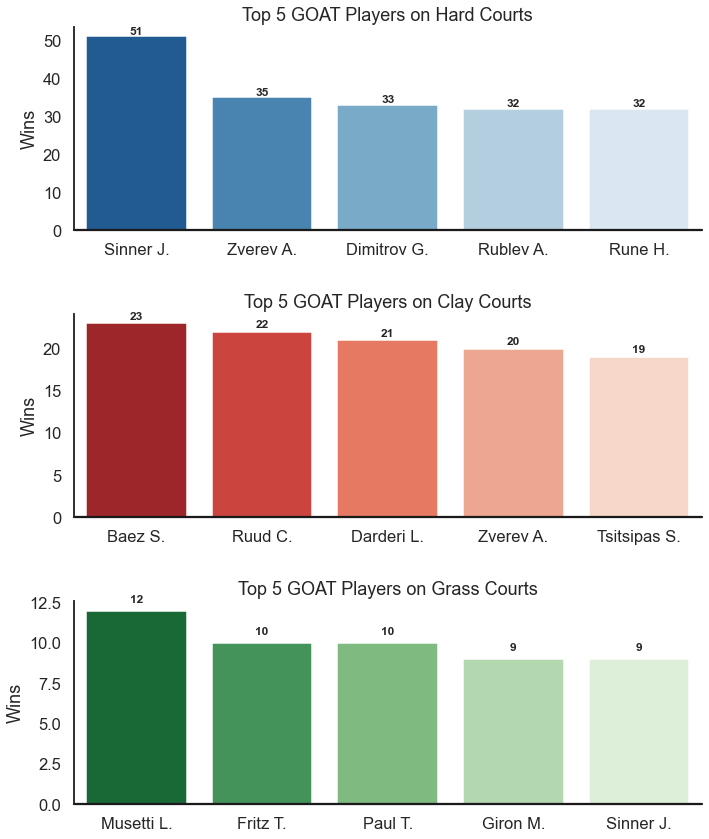

In [6]:
# Plot of the 5 best players on each surface across the whole dataset 
# (i.e. per year and not dependant of the location)

sns.set_theme(style="white", context="talk")

# Available surfaces in the dataset
available_surfaces = [surface for surface in ["Hard", "Clay", "Grass"] if surface in surface_counts]

for surface in available_surfaces:
    win_surface_df = surface_counts[surface].reset_index().sort_values(by=surface, ascending=False)
    win_surface_df.to_csv(output_folder + f"overall_goat_surfaces/wins_{surface.lower()}_{year}.csv", index=False)

# Find the top 5 players for each surface
top_players = {surface: surface_counts[[surface]].nlargest(5, surface).reset_index() for surface in available_surfaces}

fig, axes = plt.subplots(len(available_surfaces), 1, figsize=(10, 4 * len(available_surfaces)), sharex=False)

def add_annotations(ax, data, column):
    for i, v in enumerate(data[column]):
        ax.text(i, v + 0.5, str(v), ha='center', fontsize=12, fontweight='bold')

palette_map = {"Hard": "Blues_r", "Clay": "Reds_r", "Grass": "Greens_r"}

if len(available_surfaces) == 1:
    axes = [axes]

for i, surface in enumerate(available_surfaces):
    sns.barplot(
        x="Winner",
        y=surface,
        data=top_players[surface],
        palette=palette_map[surface],
        ax=axes[i]
    )
    axes[i].set_title(f"Top 5 GOAT Players on {surface} Courts")
    axes[i].set_ylabel("Wins")
    axes[i].set_xlabel("")
    axes[i].axhline(0, color="k", clip_on=False)
    add_annotations(axes[i], top_players[surface], surface)

sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

plt.show()

# 2. Best players on each surface, per city/continent in {year}

In [7]:
# Get the location and convert them to continent 
# in order to be able to find the GOAT on each surface for each city/continent

locations = ultimate['Location'].unique()

# Search continent for each city (location)
geolocator = Nominatim(user_agent="geoapi")

def get_continent(city):
    time.sleep(1)
    try:
        location = geolocator.geocode(city, featuretype='city', language="en") 
        country_code = location.address.split(",")[-1].strip()  # Extract country code
        # Convert country code to continent code
        continent_code = pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country_code)) 
        return continent_code
    except:
        return "Unknown"
    
# Mapping of cities to continents
continent_mapping = {city: get_continent(city) for city in locations}

ultimate_filtered = ultimate_filtered.copy()

# Apply mapping to the dataset
ultimate_filtered.loc[:, 'Continent'] = ultimate_filtered['Location'].map(continent_mapping)

  Continent
0        OC
1        AS
2        EU
3        SA
4        NA
5   Unknown
6        AF


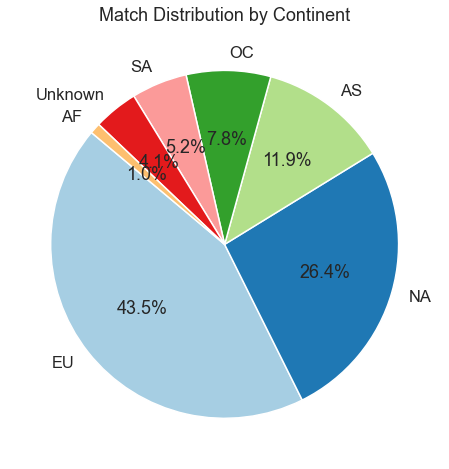

In [8]:
# Count the number of matches per continent
continent_counts = ultimate_filtered[['Continent']].value_counts()
continent_codes = [continent[0] for continent in continent_counts.index]

print(ultimate_filtered[['Continent']].drop_duplicates().reset_index(drop=True))

# Plot pie chart of match distribution across continents using Matplotlib
plt.figure(figsize=(8, 8))
plt.pie(continent_counts, labels=continent_codes, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Match Distribution by Continent")
plt.show()

In [9]:
# Find the best player for each city on each surface 
# (Usually every city has only one surface's type)
# Save the classement in each city in {year} for each surface

city_results = {}
unique_cities = ultimate_filtered['Location'].unique()
 
def save_csv_cities(df, surface, city): 
    sorted_df = df[surface].sort_values(ascending=False)
    file_name = output_folder + f"cities_goat/{city}_goat_players_on_{surface}_{year}.csv"
    sorted_df.to_csv(file_name, index=True)

for city in unique_cities:

    city_df = ultimate[ultimate['Location'] == city]

    # Compute wins by surface for this city
    city_surface_counts = city_df.groupby(['Winner', 'Surface']).size().unstack(fill_value=0)

    city_results[city] = city_surface_counts
    
    print(f"City: {city}")
    if 'Grass' in city_surface_counts: 
        best_grass = city_surface_counts['Grass'].idxmax()
        print(f"🎾 GOAT Grass Court Player in {city} in {year} 🎾: {best_grass} with {city_surface_counts.loc[best_grass, 'Grass']} wins")
        save_csv_cities(city_surface_counts, 'Grass', city)
        
    if 'Clay' in city_surface_counts: 
        best_clay = city_surface_counts['Clay'].idxmax()
        print(f"🎾 GOAT Clay Court Player in {city} in {year} 🎾: {best_clay} with {city_surface_counts.loc[best_clay, 'Clay']} wins")
        save_csv_cities(city_surface_counts, 'Clay', city)
        
    if 'Hard' in city_surface_counts: 
        best_hard = city_surface_counts['Hard'].idxmax()
        print(f"🎾 GOAT Hard Court Player in {city} in {year} 🎾: {best_hard} with {city_surface_counts.loc[best_hard, 'Hard']} wins")
        save_csv_cities(city_surface_counts, 'Hard', city)
    print("="*40)

City: Brisbane
🎾 GOAT Hard Court Player in Brisbane in 2024 🎾: Dimitrov G. with 5 wins
City: Hong Kong
🎾 GOAT Hard Court Player in Hong Kong in 2024 🎾: Rublev A. with 4 wins
City: Adelaide
🎾 GOAT Hard Court Player in Adelaide in 2024 🎾: Lehecka J. with 5 wins
City: Auckland
🎾 GOAT Hard Court Player in Auckland in 2024 🎾: Tabilo A. with 5 wins
City: Melbourne
🎾 GOAT Hard Court Player in Melbourne in 2024 🎾: Sinner J. with 7 wins
City: Montpellier
🎾 GOAT Hard Court Player in Montpellier in 2024 🎾: Bublik A. with 4 wins
City: Cordoba
🎾 GOAT Clay Court Player in Cordoba in 2024 🎾: Darderi L. with 5 wins
City: Dallas
🎾 GOAT Hard Court Player in Dallas in 2024 🎾: Giron M. with 4 wins
City: Marseille
🎾 GOAT Hard Court Player in Marseille in 2024 🎾: Humbert U. with 4 wins
City: Buenos Aires
🎾 GOAT Clay Court Player in Buenos Aires in 2024 🎾: Diaz Acosta F. with 5 wins
City: Delray Beach
🎾 GOAT Hard Court Player in Delray Beach in 2024 🎾: Fritz T. with 4 wins
City: Rotterdam
🎾 GOAT Hard Court P

In [10]:
# Here, CSVs are separated by continent AND by surface

continent_results = {}
unique_continents = ultimate_filtered['Continent'].unique()

def save_csv_continent(df, surface, continent): 
    sorted_df = df[surface].sort_values(ascending=False)
    file_name = output_folder + f"continent_goat/{continent.lower()}_goat_players_on_{surface}_{year}.csv"
    sorted_df.to_csv(file_name, index=True)

for continent in unique_continents:
    if (continent == "Unknown"): continue
    continent_df = ultimate_filtered[ultimate_filtered['Continent'] == continent]
    
    # Compute wins by surface for this continent
    continent_surface_counts = continent_df.groupby(['Winner', 'Surface']).size().unstack(fill_value=0)

    continent_results[continent] = continent_surface_counts

    print(f"Continent: {continent}")

    if 'Grass' in continent_surface_counts: 
        best_grass = continent_surface_counts['Grass'].idxmax()
        print(f"🎾 Best Grass Court Player in {continent} 🎾: {best_grass} with {continent_surface_counts.loc[best_grass, 'Grass']} wins")
        save_csv_continent(continent_surface_counts, 'Grass', continent)
        
    if 'Clay' in continent_surface_counts: 
        best_clay = continent_surface_counts['Clay'].idxmax()
        print(f"🎾 Best Clay Court Player in {continent} 🎾: {best_clay} with {continent_surface_counts.loc[best_clay, 'Clay']} wins")
        save_csv_continent(continent_surface_counts, 'Clay', continent)

    
    if 'Hard' in continent_surface_counts: 
        best_hard = continent_surface_counts['Hard'].idxmax()
        print(f"🎾 Best Hard Court Player in {continent} 🎾: {best_hard} with {continent_surface_counts.loc[best_hard, 'Hard']} wins")
        save_csv_continent(continent_surface_counts, 'Hard', continent)

    print("="*40)

Continent: OC
🎾 Best Hard Court Player in OC 🎾: Dimitrov G. with 7 wins
Continent: AS
🎾 Best Hard Court Player in AS 🎾: Humbert U. with 11 wins
Continent: EU
🎾 Best Grass Court Player in EU 🎾: Sinner J. with 9 wins
🎾 Best Clay Court Player in EU 🎾: Zverev A. with 19 wins
🎾 Best Hard Court Player in EU 🎾: De Minaur A. with 12 wins
Continent: SA
🎾 Best Clay Court Player in SA 🎾: Baez S. with 9 wins
Continent: NA
🎾 Best Grass Court Player in NA 🎾: Giron M. with 4 wins
🎾 Best Clay Court Player in NA 🎾: Darderi L. with 5 wins
🎾 Best Hard Court Player in NA 🎾: Sinner J. with 24 wins
Continent: AF
🎾 Best Clay Court Player in AF 🎾: Berrettini M. with 5 wins


In [11]:
# Here csv are separated only by surface 
top_grass_players = []
top_clay_players = []
top_hard_players = []

# Loop through each continent (excluding "Unknown")
for continent in unique_continents:
    if continent == "Unknown":
        continue

    # Filter DataFrame for this continent
    continent_df = ultimate_filtered[ultimate_filtered['Continent'] == continent]

    # Compute wins by surface
    continent_surface_counts = (
        continent_df.groupby(['Winner', 'Surface'])
        .size()
        .unstack(fill_value=0)
        .reset_index()
    )

    # Get the top 5 players separately for each surface
    for surface, container in zip(["Grass", "Clay", "Hard"], 
                                  [top_grass_players, top_clay_players, top_hard_players]):
        if surface in continent_surface_counts:
            top_surface = continent_surface_counts.nlargest(5, surface)[['Winner', surface]]
            for _, row in top_surface.iterrows():
                container.append({
                    "Continent": continent,
                    "Winner": row["Winner"],
                    "Surface": surface,
                    "Wins": row[surface]
                })

# Convert collected data into separate DataFrames
if grass: grass_df = pd.DataFrame(top_grass_players)
if clay: clay_df = pd.DataFrame(top_clay_players)
if hard: hard_df = pd.DataFrame(top_hard_players)

if grass: grass_df.to_csv(output_folder + f"continent_goat/top_grass_players_by_continent_{year}.csv", index=False)
if clay: clay_df.to_csv(output_folder + f"continent_goat/top_clay_players_by_continent_{year}.csv", index=False)
if hard: hard_df.to_csv(output_folder + f"continent_goat/top_hard_players_by_continent_{year}.csv", index=False)

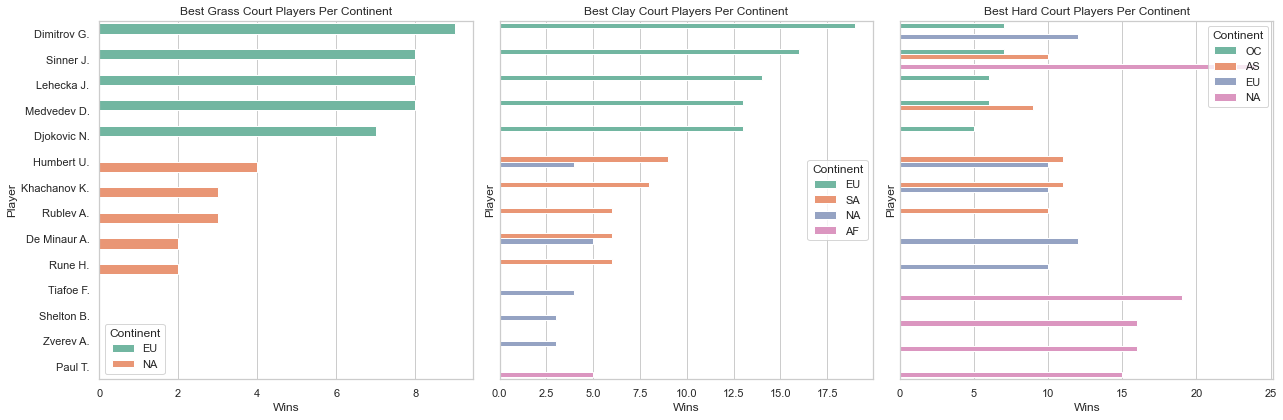

In [12]:
sns.set_theme(style="whitegrid")

surface_data = {
    "Grass": grass_df if grass else None,
    "Clay": clay_df if clay else None,
    "Hard": hard_df if hard else None
}

active_surfaces = {key: value for key, value in surface_data.items() if value is not None}
num_surfaces = len(active_surfaces)

fig, axes = plt.subplots(1, num_surfaces, figsize=(6 * num_surfaces, 6), sharey=True)

if num_surfaces == 1:
    axes = [axes]

# Plot function
def plot_by_surface(surface, df, ax):
    sns.barplot(
        data=df,
        x="Wins",
        y="Winner",
        hue="Continent",
        palette="Set2",
        ax=ax
    )
    ax.set_title(f"Best {surface} Court Players Per Continent")
    ax.set_xlabel("Wins")
    ax.set_ylabel("Player")

for i, (surface, df) in enumerate(active_surfaces.items()):
    plot_by_surface(surface, df, axes[i])

plt.tight_layout()
plt.show()

# 3. Best players on each surface, per tournaments in {year}

In [13]:
tournament_names = ultimate['Tournament'].unique()

# Count the number of matches per Tournament
tournament_counts = ultimate_filtered[['Tournament']].value_counts()

print(tournament_counts)

Tournament            
Wimbledon                 127
French Open               127
US Open                   127
Australian Open           127
Mutua Madrid Open          95
                         ... 
Lyon Open                  27
Mallorca Championships     27
Chile Open                 27
Nordea Open                27
Masters Cup                15
Length: 64, dtype: int64


In [14]:
# Find the best player for each city on each surface 
# (Usually every city has only one surface's type)
# Save the classement in each city in {year} for each surface

tournament_results = {}
 
def save_csv_tournament(df, surface, tournament): 
    sorted_df = df[surface].sort_values(ascending=False)
    file_name = output_folder + f"tournament_goat/{tournament}_goat_players_on_{surface}_{year}.csv"
    sorted_df.to_csv(file_name, index=True)

for tournament in tournament_names:

    tournament_df = ultimate[ultimate['Tournament'] == tournament]

    # Compute wins by surface for each tournament
    tournament_surface_counts = tournament_df.groupby(['Winner', 'Surface']).size().unstack(fill_value=0)

    tournament_results[tournament] = tournament_surface_counts
    
    print(f"Tournament: {tournament}")
    if 'Grass' in tournament_surface_counts: 
        best_grass = tournament_surface_counts['Grass'].idxmax()
        print(f"🎾 GOAT Grass Court Player in {tournament} in {year} 🎾: {best_grass} with {tournament_surface_counts.loc[best_grass, 'Grass']} wins")
        save_csv_tournament(tournament_surface_counts, 'Grass', tournament)
        
    if 'Clay' in tournament_surface_counts: 
        best_clay = tournament_surface_counts['Clay'].idxmax()
        print(f"🎾 GOAT Clay Court Player in {tournament} in {year} 🎾: {best_clay} with {tournament_surface_counts.loc[best_clay, 'Clay']} wins")
        save_csv_tournament(tournament_surface_counts, 'Clay', tournament)
        
    if 'Hard' in tournament_surface_counts: 
        best_hard = tournament_surface_counts['Hard'].idxmax()
        print(f"🎾 GOAT Hard Court Player in {tournament} in {year} 🎾: {best_hard} with {tournament_surface_counts.loc[best_hard, 'Hard']} wins")
        save_csv_tournament(tournament_surface_counts, 'Hard', tournament)
    print("="*40)

Tournament: Brisbane International
🎾 GOAT Hard Court Player in Brisbane International in 2024 🎾: Dimitrov G. with 5 wins
Tournament: Hong Kong Tennis Open
🎾 GOAT Hard Court Player in Hong Kong Tennis Open in 2024 🎾: Rublev A. with 4 wins
Tournament: Adelaide International
🎾 GOAT Hard Court Player in Adelaide International in 2024 🎾: Lehecka J. with 5 wins
Tournament: ASB Classic
🎾 GOAT Hard Court Player in ASB Classic in 2024 🎾: Tabilo A. with 5 wins
Tournament: Australian Open
🎾 GOAT Hard Court Player in Australian Open in 2024 🎾: Sinner J. with 7 wins
Tournament: Open Sud de France
🎾 GOAT Hard Court Player in Open Sud de France in 2024 🎾: Bublik A. with 4 wins
Tournament: Cordoba Open
🎾 GOAT Clay Court Player in Cordoba Open in 2024 🎾: Darderi L. with 5 wins
Tournament: Dallas Open
🎾 GOAT Hard Court Player in Dallas Open in 2024 🎾: Giron M. with 4 wins
Tournament: Open 13
🎾 GOAT Hard Court Player in Open 13 in 2024 🎾: Humbert U. with 4 wins
Tournament: Argentina Open
🎾 GOAT Clay Cour

Tournament: Belgrade Open
🎾 GOAT Hard Court Player in Belgrade Open in 2024 🎾: Shapovalov D. with 5 wins
Tournament: Open de Moselle
🎾 GOAT Hard Court Player in Open de Moselle in 2024 🎾: Bonzi B. with 5 wins
Tournament: Masters Cup
🎾 GOAT Hard Court Player in Masters Cup in 2024 🎾: Sinner J. with 5 wins


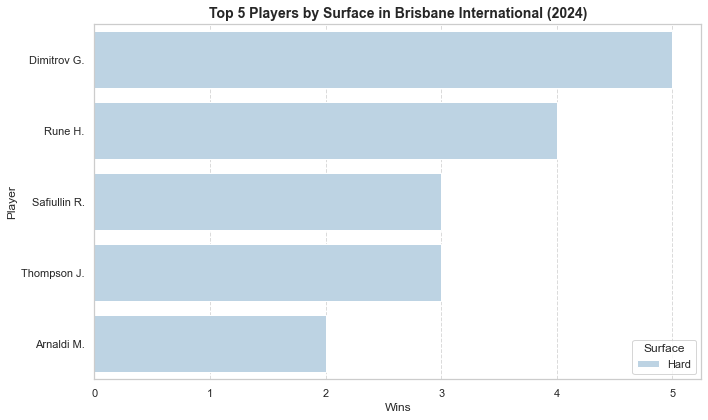

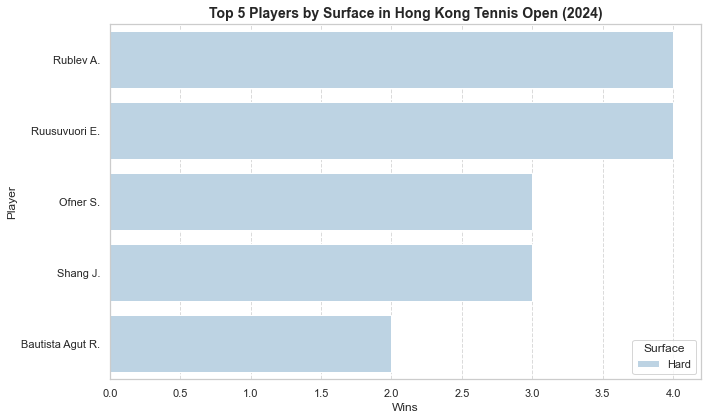

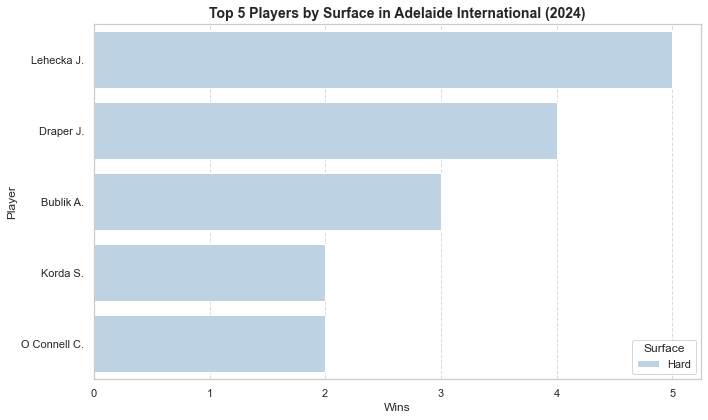

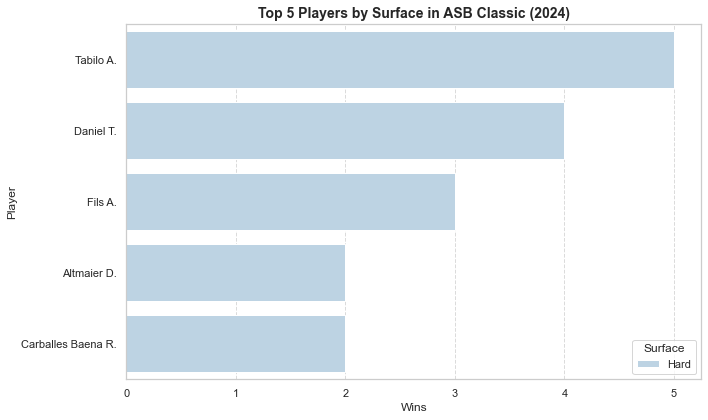

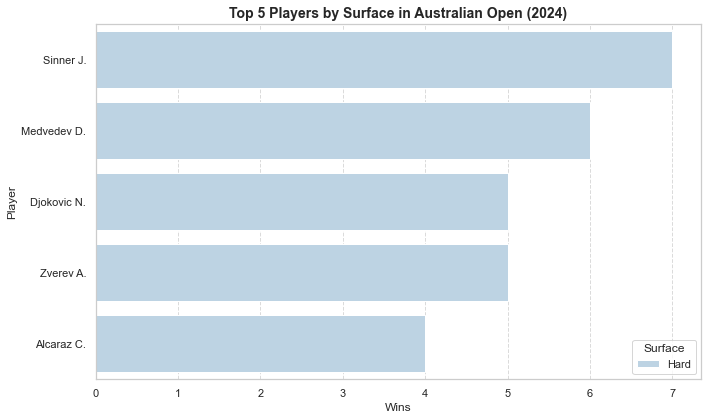

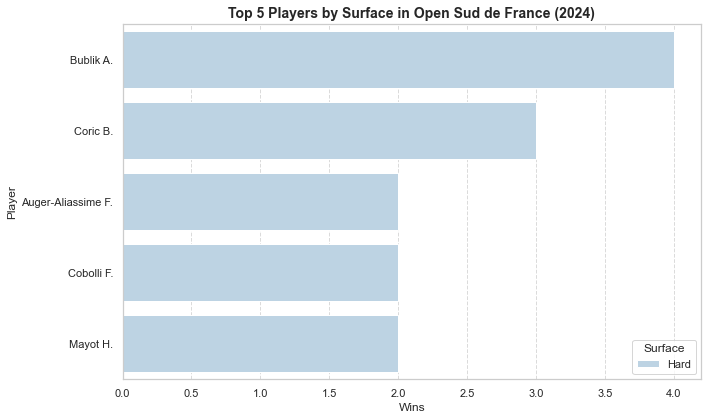

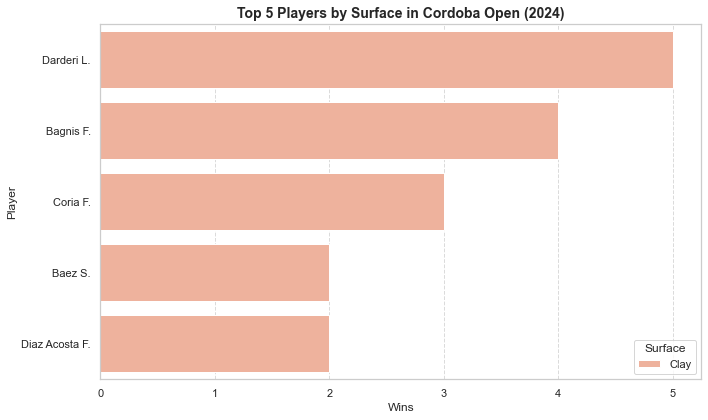

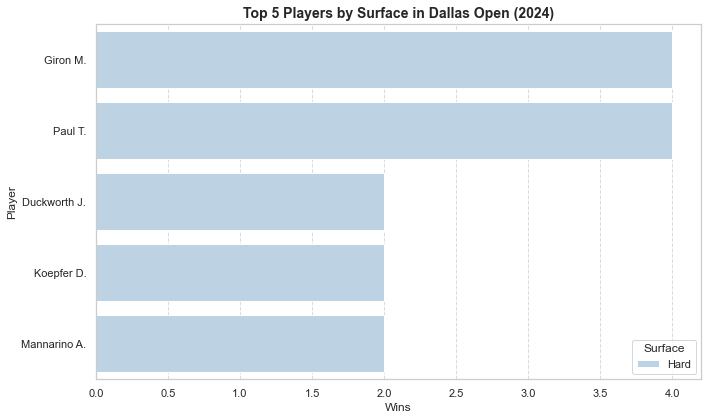

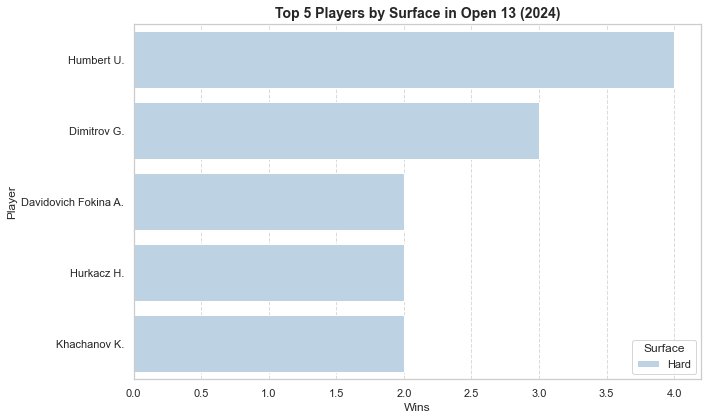

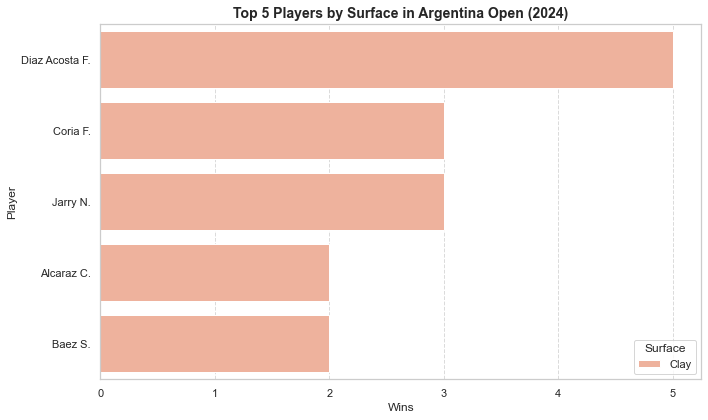

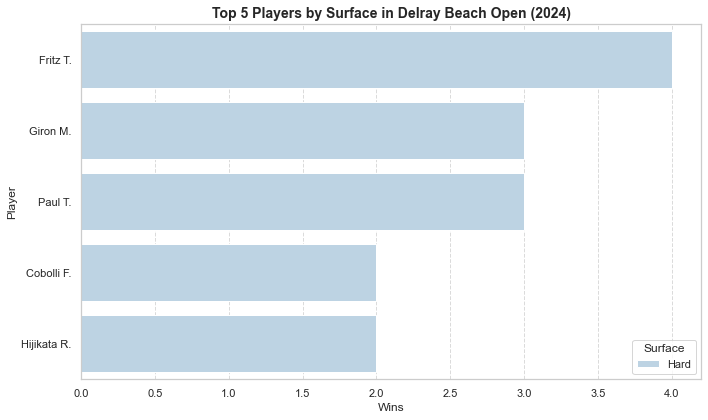

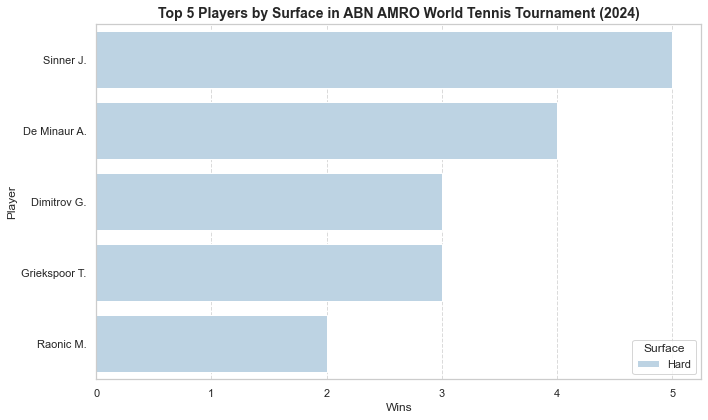

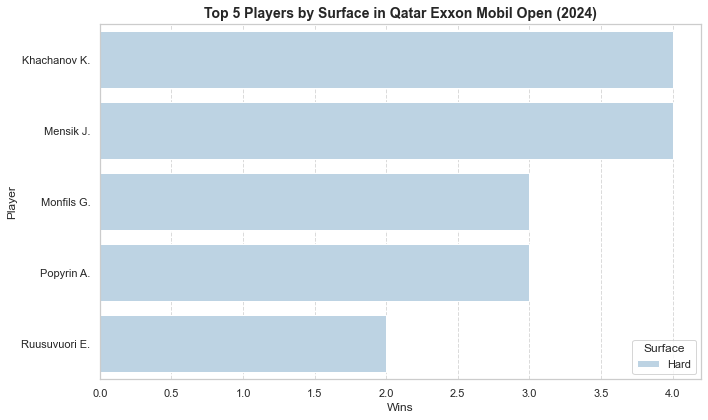

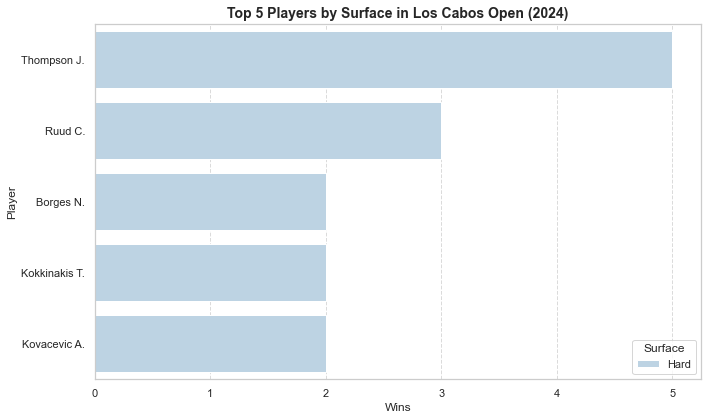

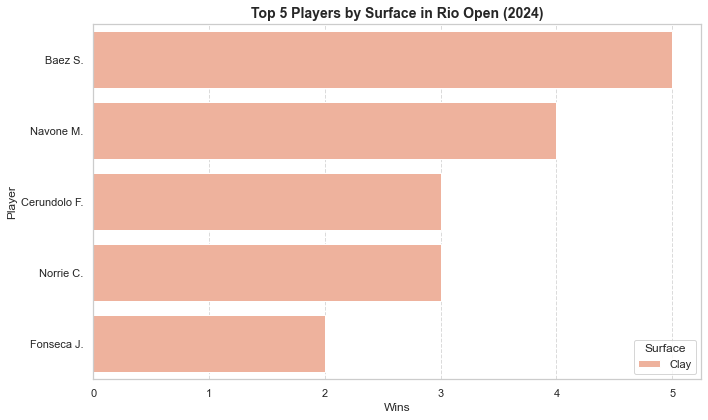

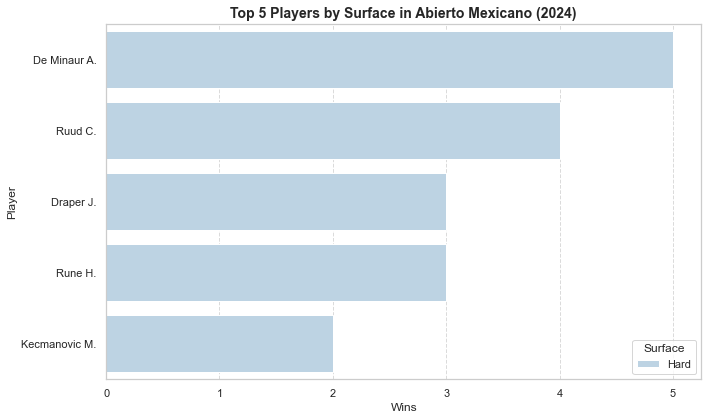

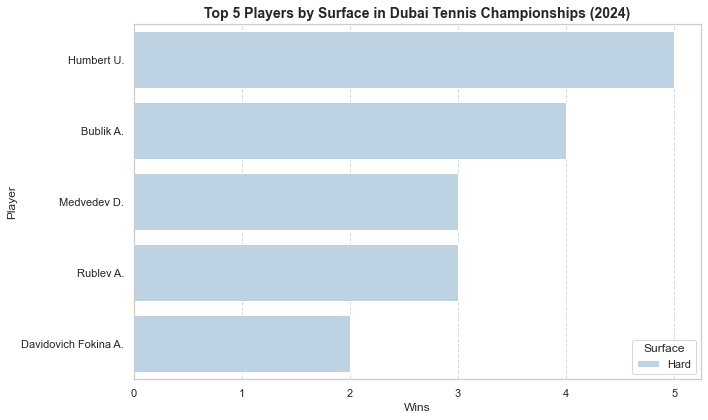

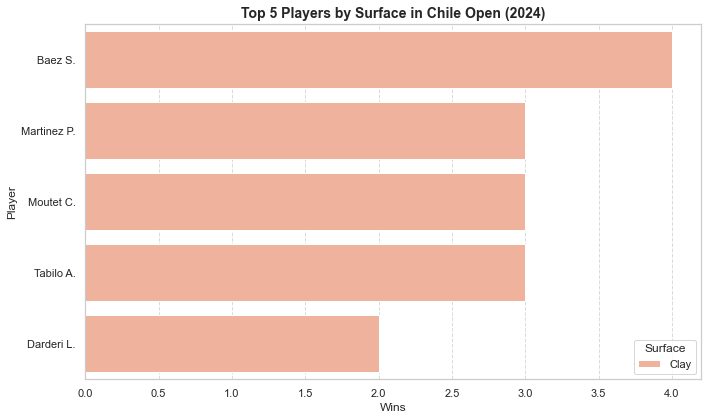

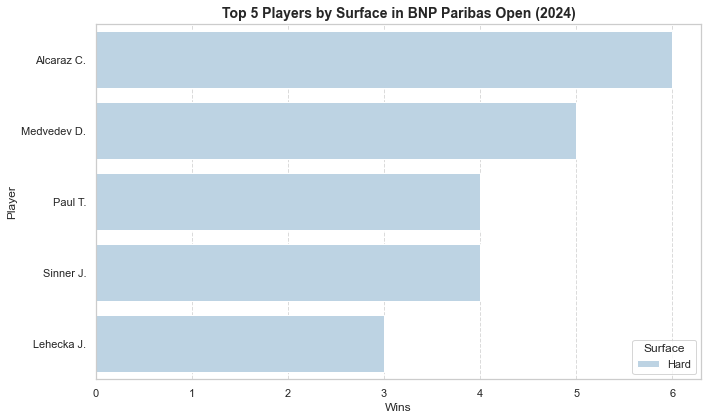

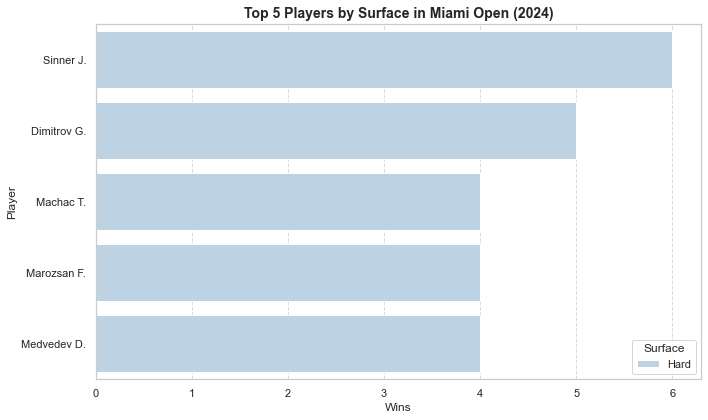

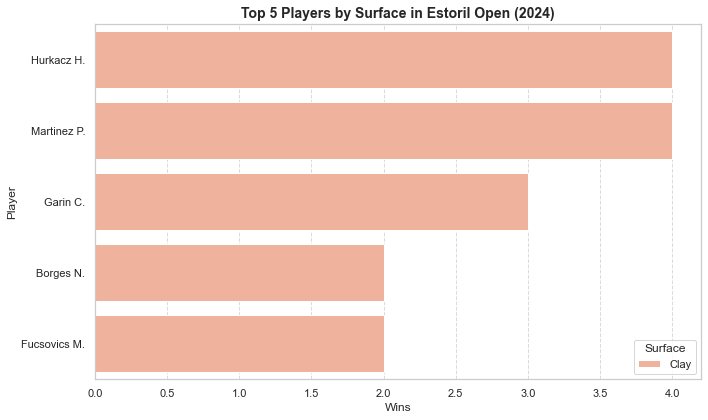

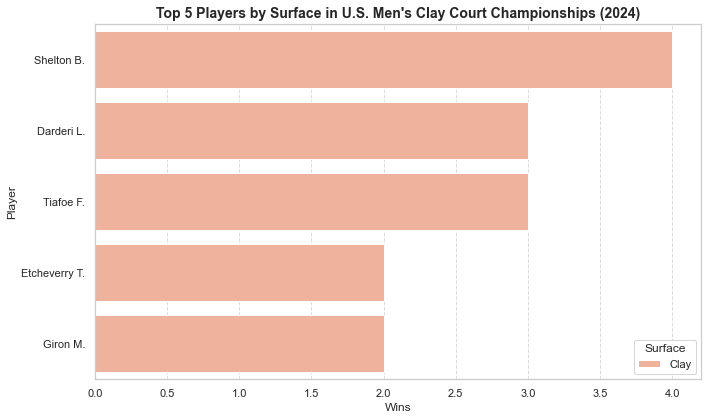

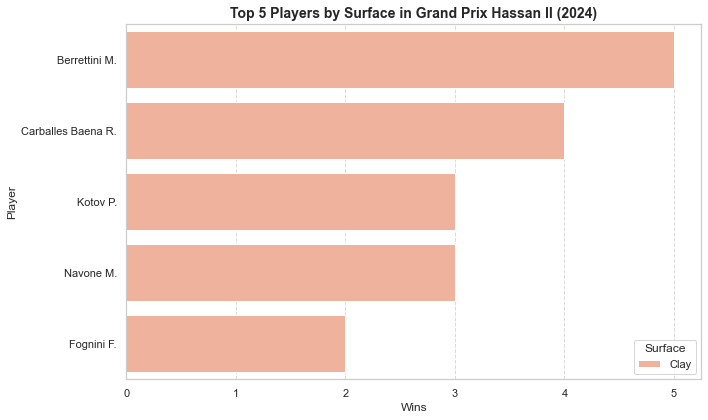

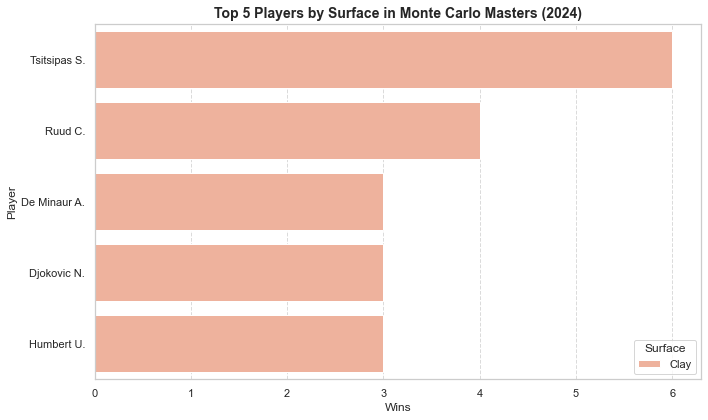

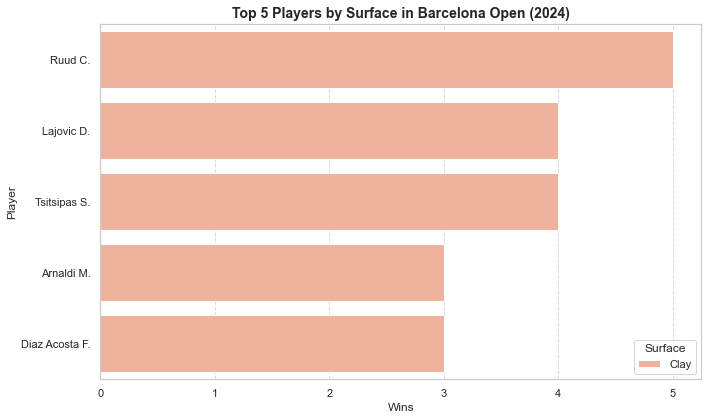

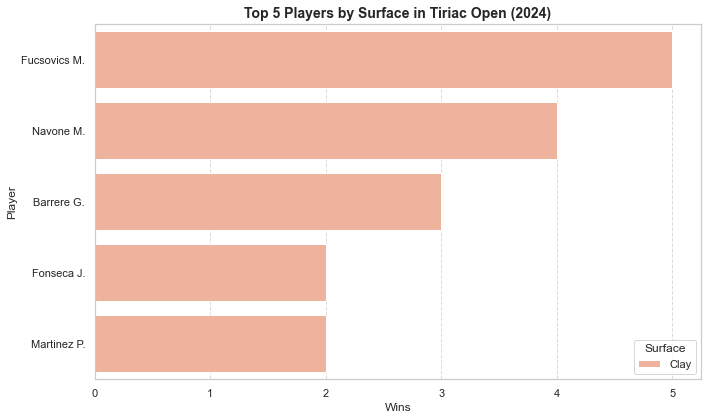

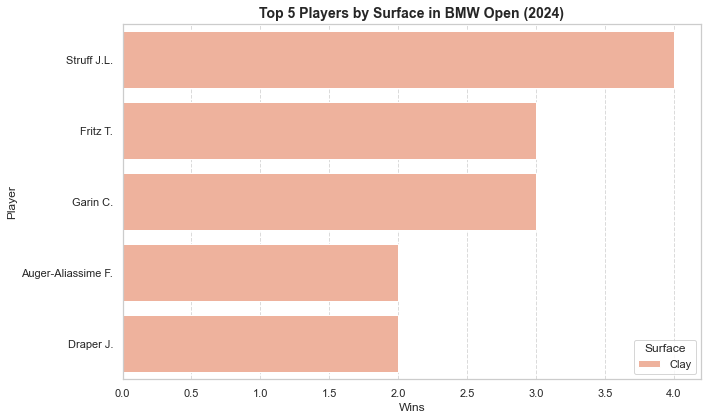

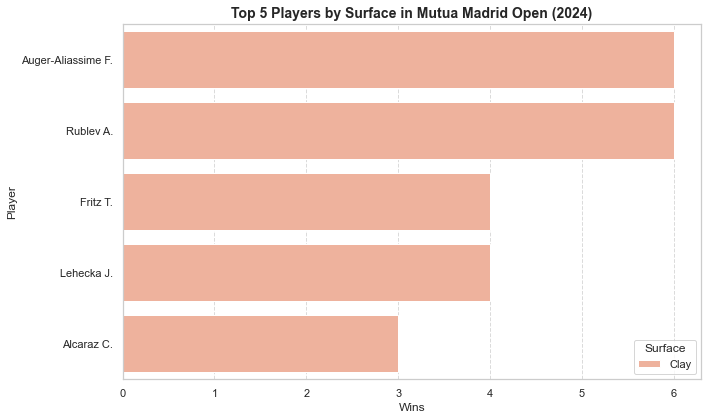

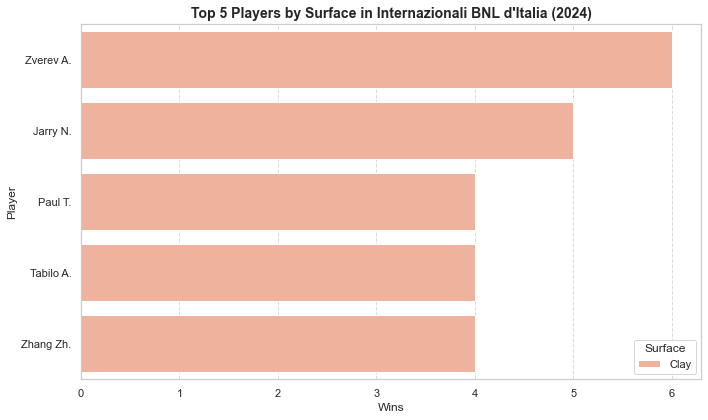

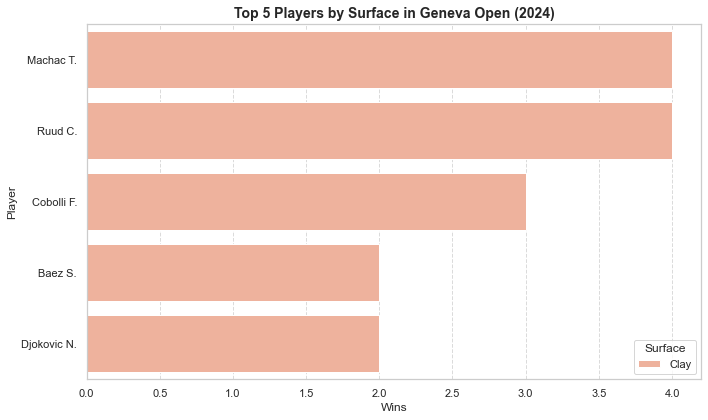

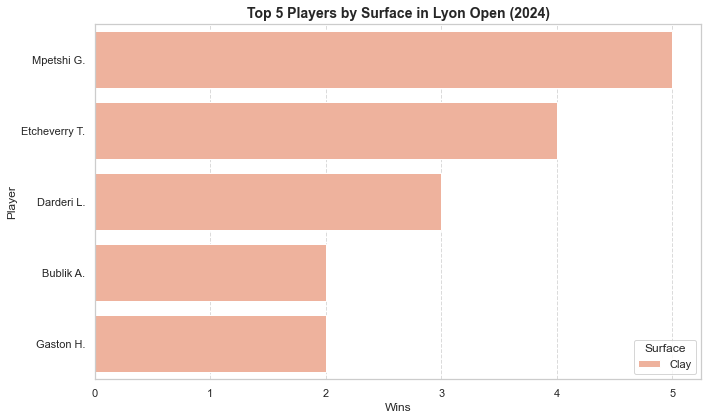

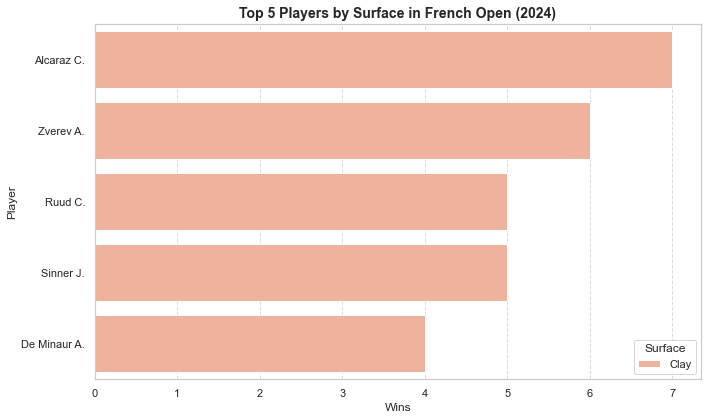

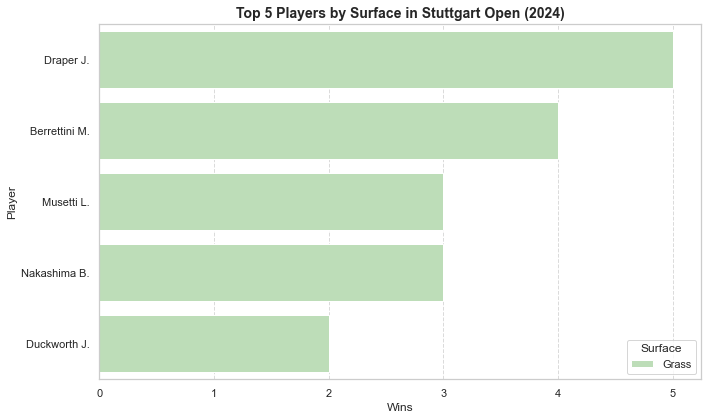

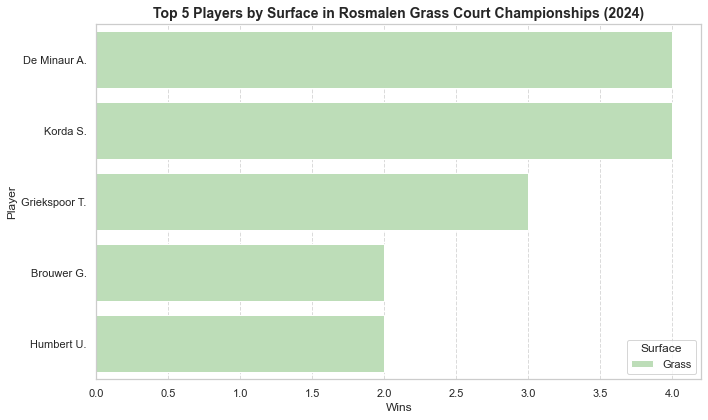

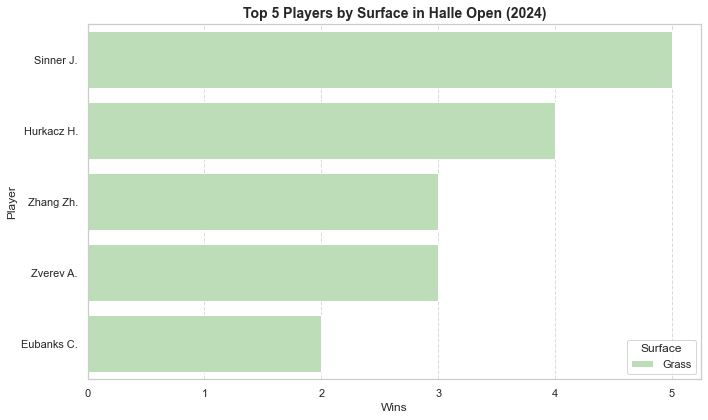

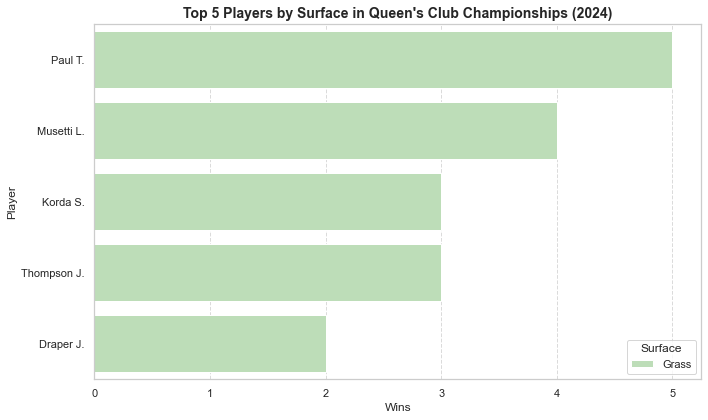

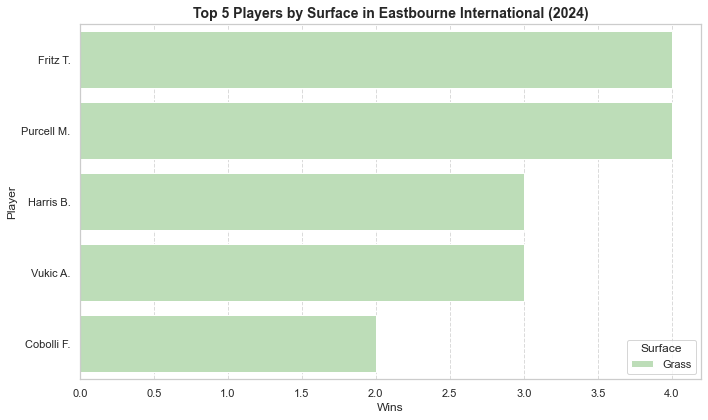

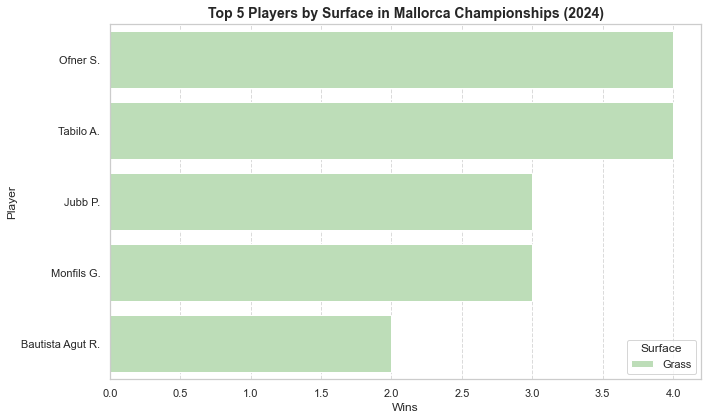

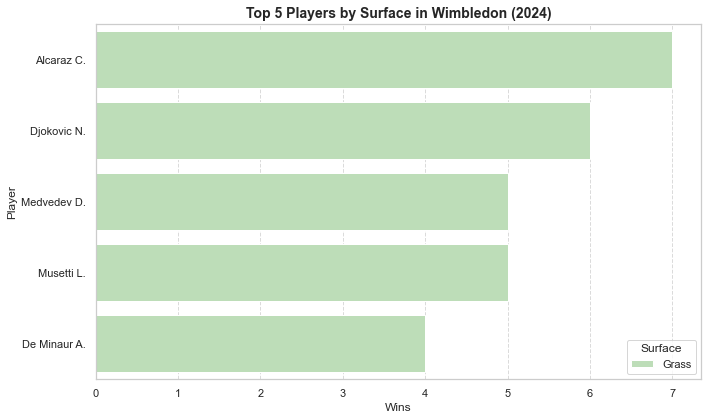

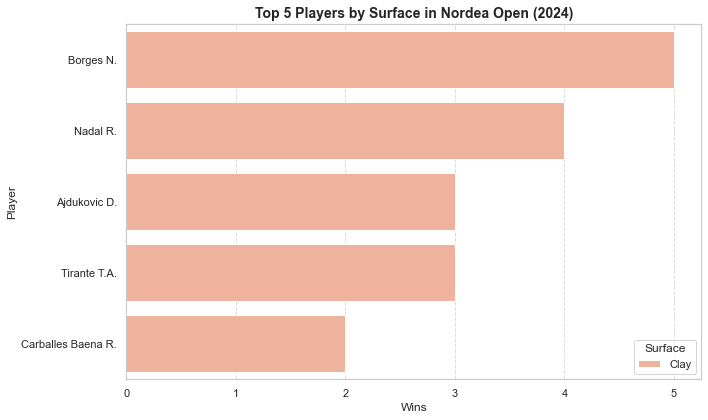

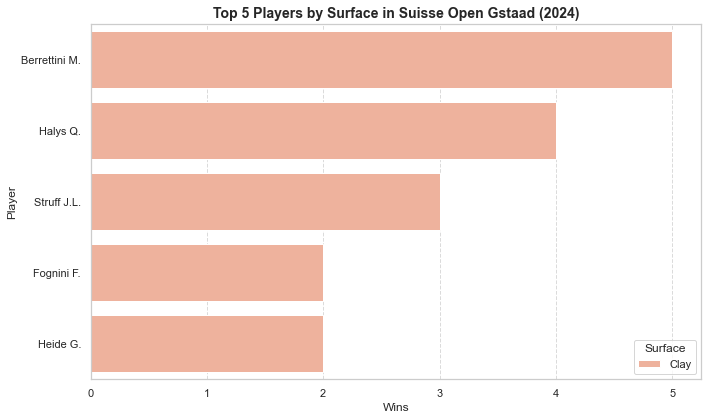

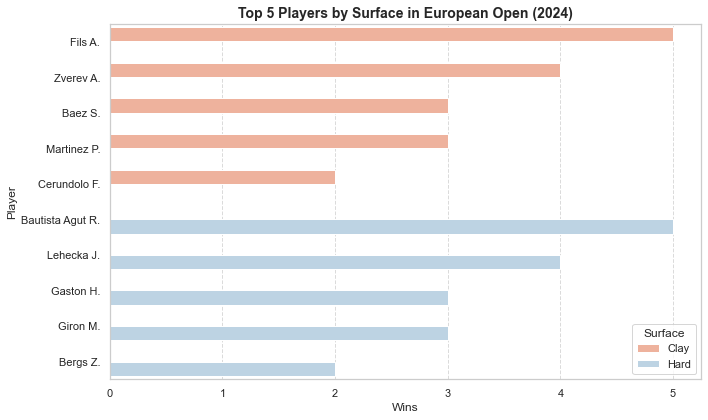

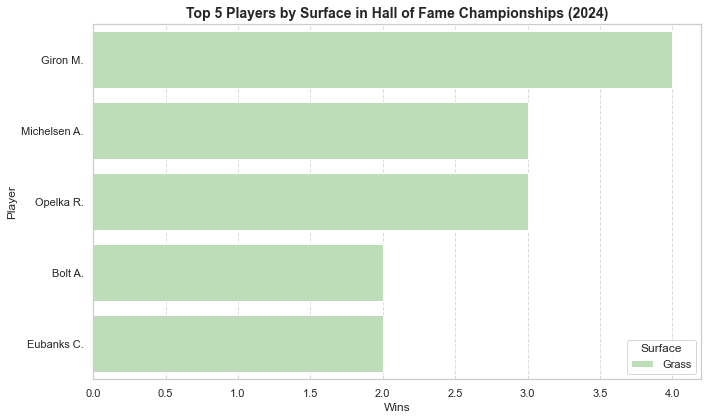

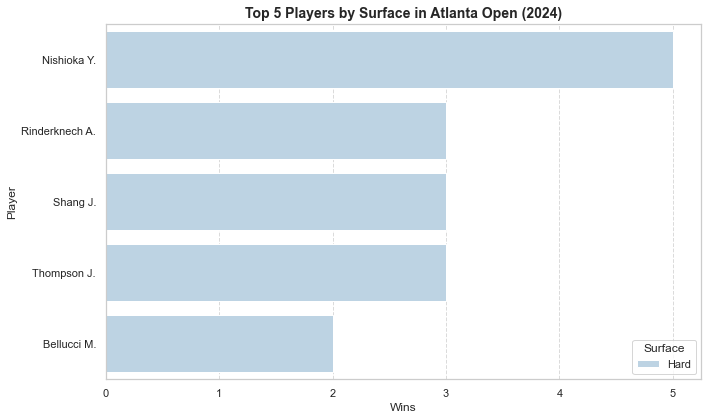

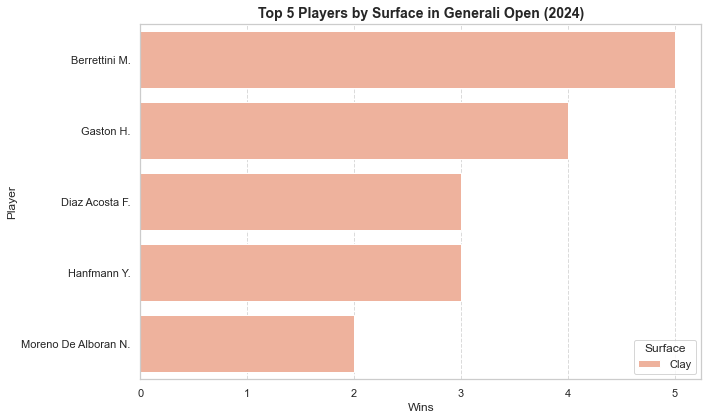

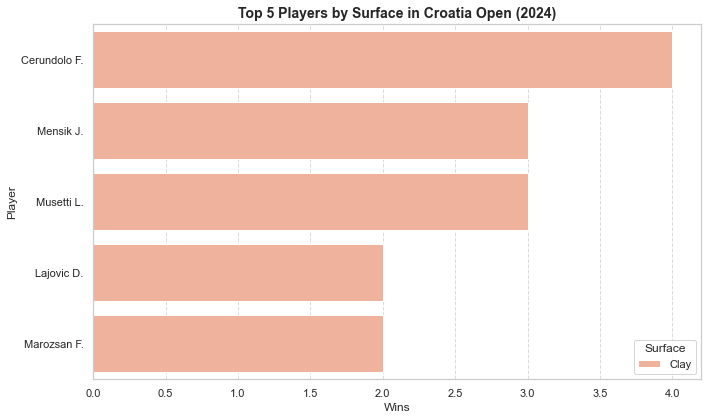

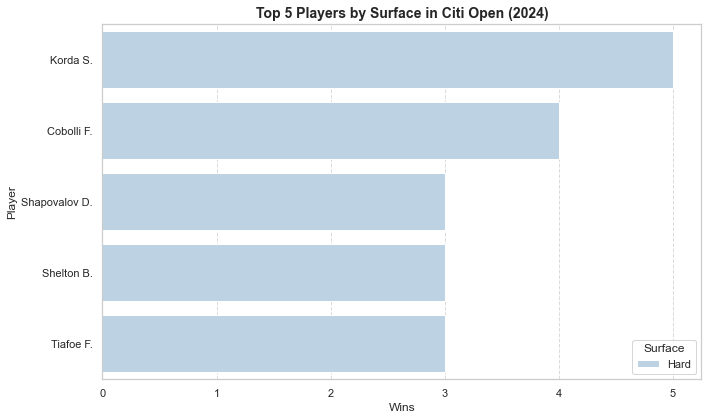

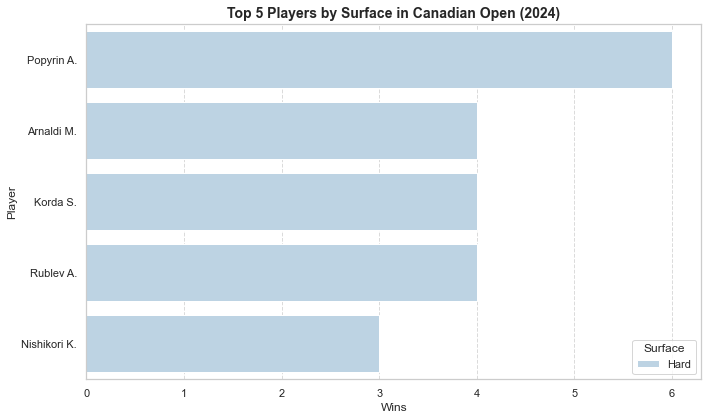

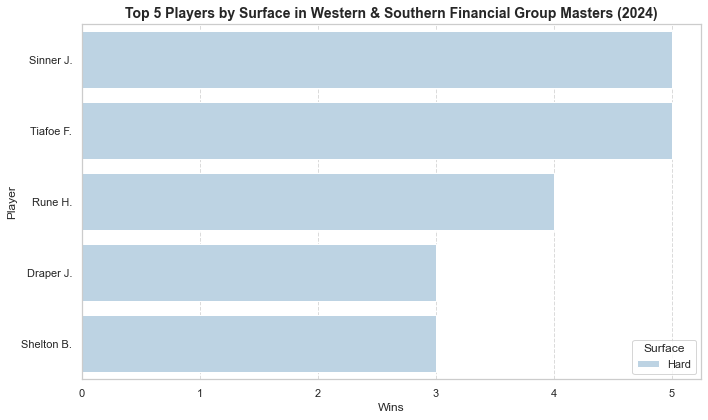

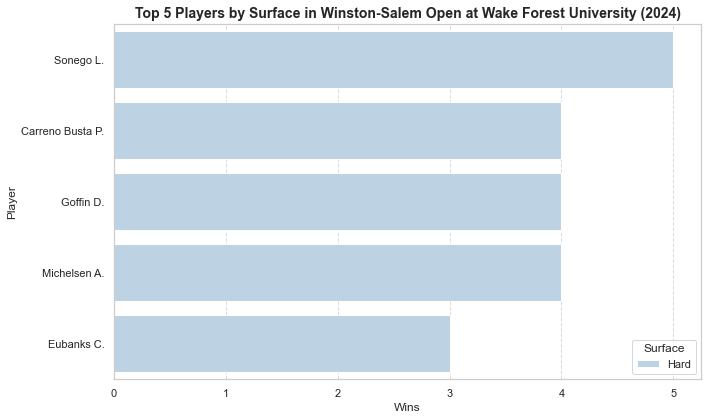

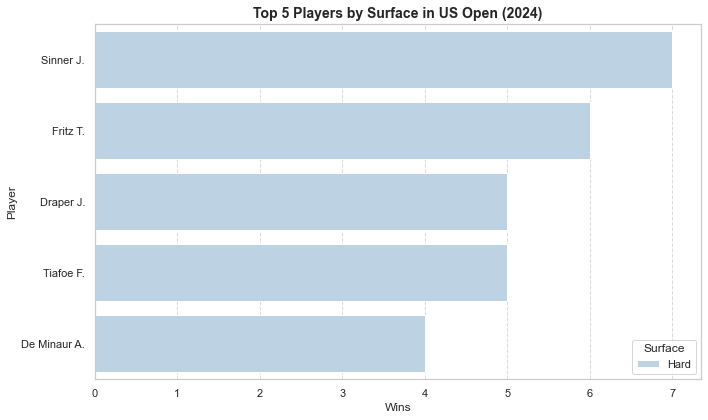

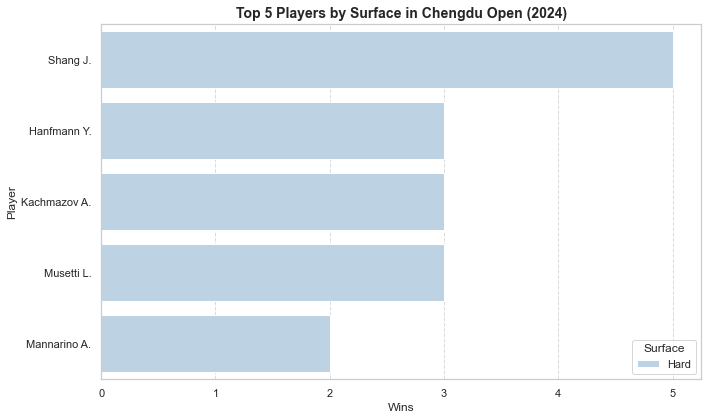

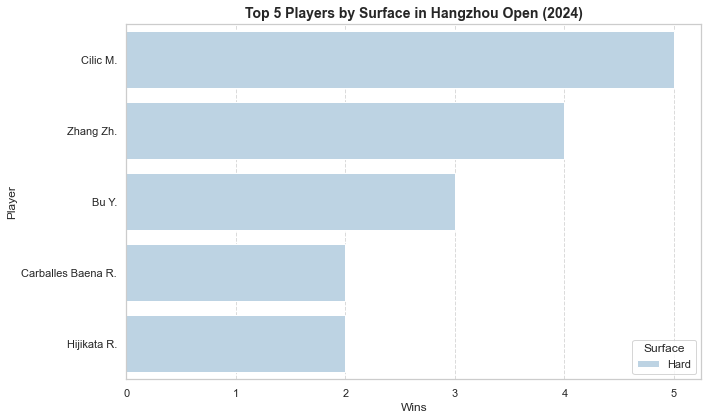

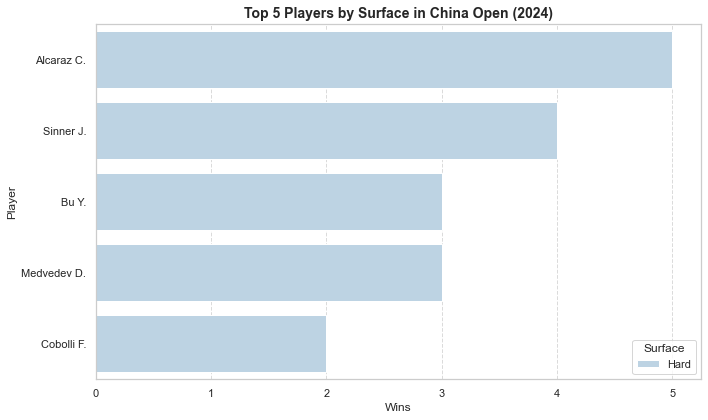

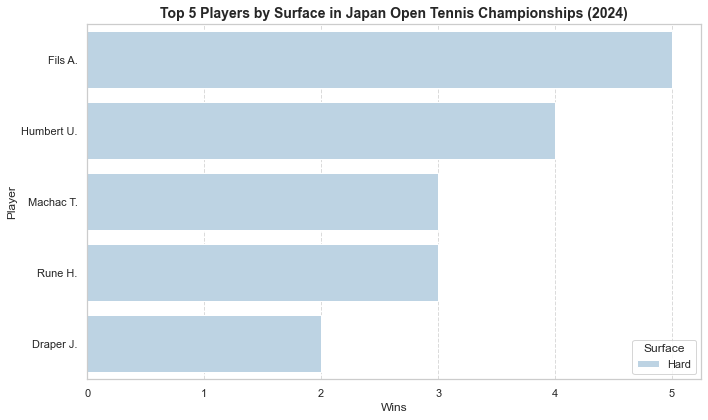

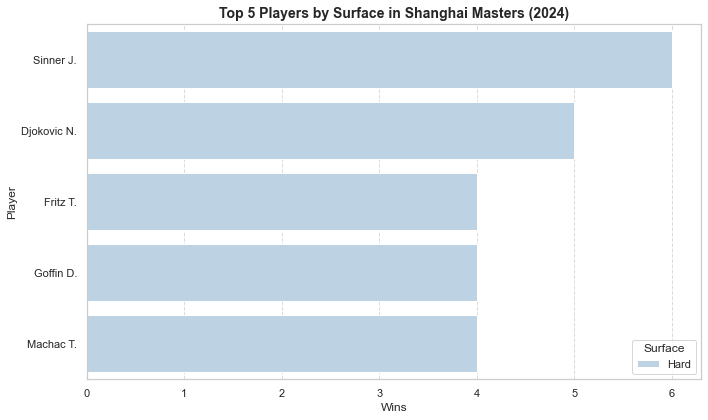

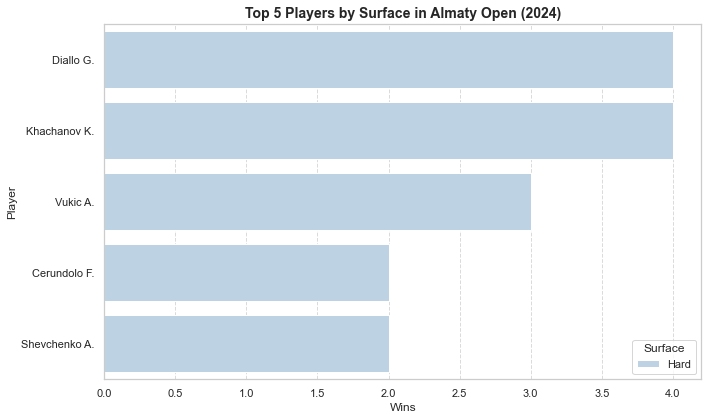

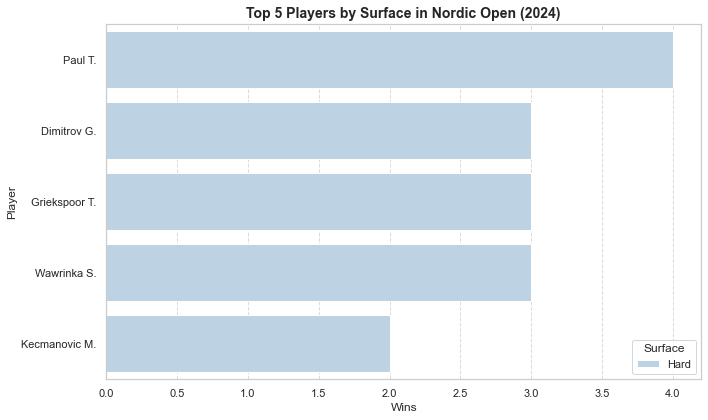

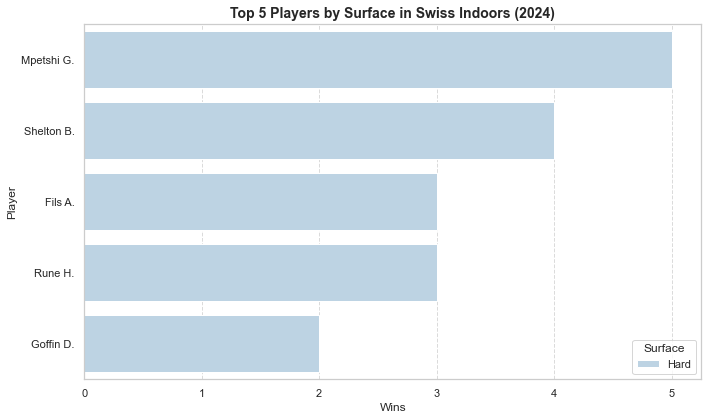

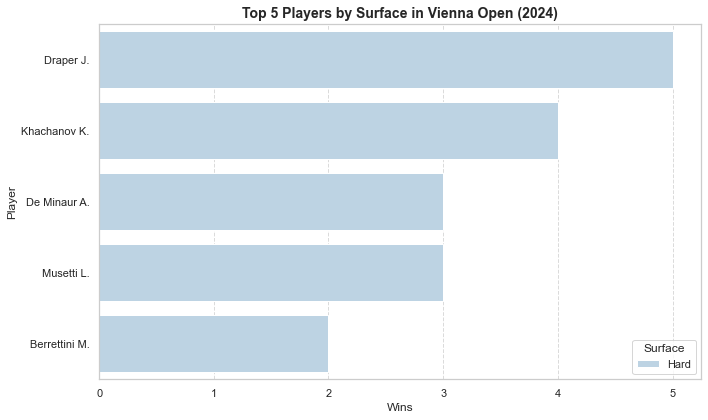

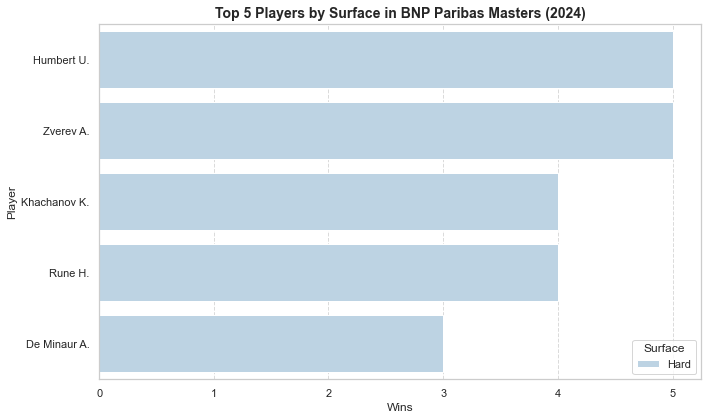

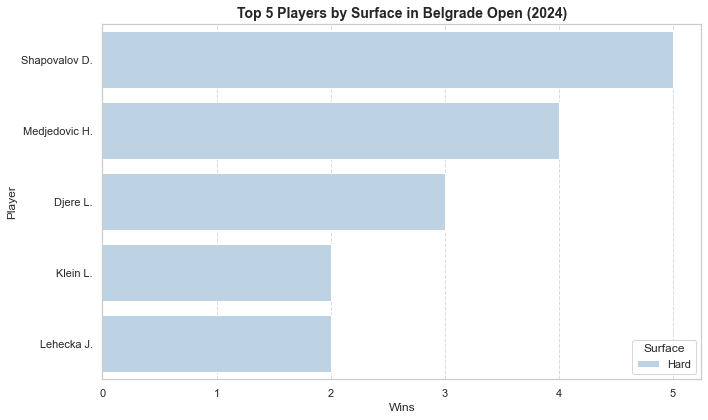

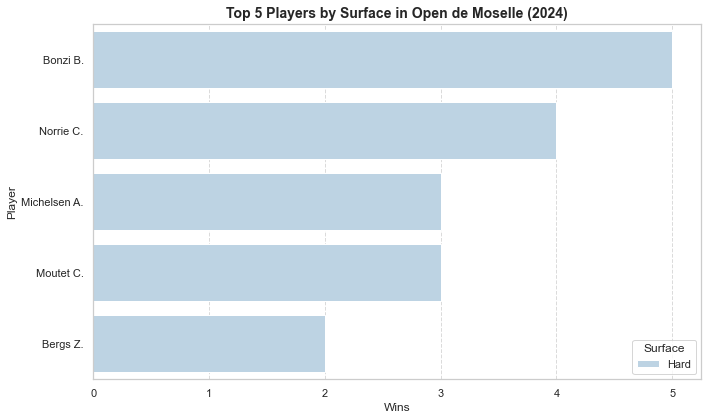

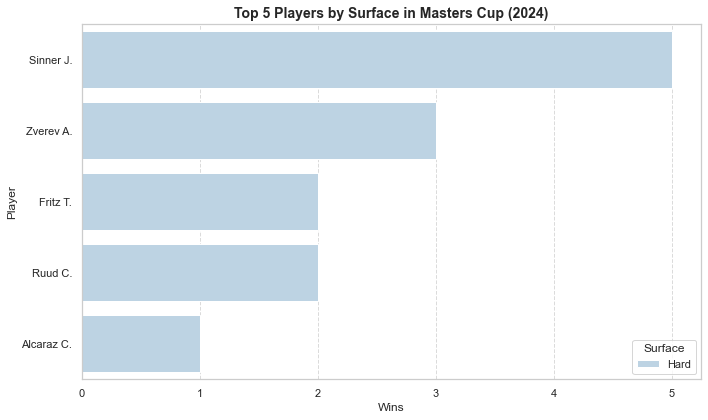

In [15]:
palette_map = {"Hard": "Blues_r", "Clay": "Reds_r", "Grass": "Greens_r"}

for tournament, df in tournament_results.items():

    df_melted = df.reset_index().melt(id_vars="Winner", var_name="Surface", value_name="Wins")

    df_melted = df_melted[df_melted["Wins"] > 0]


    top_5_players = df_melted.groupby("Surface").apply(lambda x: x.nlargest(5, "Wins")).reset_index(drop=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=top_5_players,
        x="Wins",
        y="Winner",
        hue="Surface",
        palette={surface: sns.color_palette(palette_map[surface], as_cmap=True)(0.7) for surface in top_players["Surface"].unique()}
    )

    plt.title(f"Top 5 Players by Surface in {tournament} in {year}", fontsize=14, fontweight='bold')
    plt.xlabel("Wins")
    plt.ylabel("Player")
    plt.legend(title="Surface")
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.tight_layout()

    plt.show()
